# Classification of whether an Image of Cell is Infected with Malaria or Not


In this notebook, I will build a Convolution Neural Network ML Model that will be able to predict with a certain amount of accuracy whether or not an image of a cell has been infected with Malaria or not. I will then deploy the final model using Google Cloud Platform's App Engine.


### About Malaria:

Malaria is a life-threatening disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes. It is preventable and curable.

In 2017, there were an estimated 219 million cases of malaria in 90 countries.

Malaria deaths reached 435,000 in 2017.

The WHO African Region carries a disproportionately high share of the global malaria burden. In 2017, the region was home to 92% of malaria cases and 93% of malaria deaths.

Malaria is caused by Plasmodium parasites. The parasites are spread to people through the bites of infected female Anopheles mosquitoes, called "malaria vectors." There are 5 parasite species that cause malaria in humans, and 2 of these species – P. falciparum and P. vivax – pose the greatest threat.

**Diagnosis of malaria can be difficult:**

Where malaria is not endemic any more (such as in the United States), health-care providers may not be familiar with the disease. Clinicians seeing a malaria patient may forget to consider malaria among the potential diagnoses and not order the needed diagnostic tests. Laboratorians may lack experience with malaria and fail to detect parasites when examining blood smears under the microscope.

Malaria is an acute febrile illness. In a non-immune individual, symptoms usually appear 10–15 days after the infective mosquito bite. The first symptoms – fever, headache, and chills – may be mild and difficult to recognize as malaria. If not treated within 24 hours, P. falciparum malaria can progress to severe illness, often leading to death.

**Microscopic Diagnosis**

Malaria parasites can be identified by examining under the microscope a drop of the patient’s blood, spread out as a “blood smear” on a microscope slide. Prior to examination, the specimen is stained to give the parasites a distinctive appearance. This technique remains the gold standard for laboratory confirmation of malaria. However, it depends on the quality of the reagents, of the microscope, and on the experience of the laboratorian.


#### Acknowledgements

This Dataset is taken from the official US National Library of Medicine's NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/. It is a repository of segmented cells from the thin blood smear slide images from the Malaria Screener research activity.

The dataset contains 27,558 color images and 2 folders - infected and uninfected.



## SUMMARY OF RESULTS:

Building a custom built 2-layered Convolution Neural Network provided fairly good results at 95% accuracy. F1 Score, Precision, and Recall were also at 95% for each giving us an equal and moderately low number of False Positives and False Negatives.

```
Accuracy Score: 
0.9621
'Report: 
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2805
           1       0.95      0.98      0.96      2705

   micro avg       0.96      0.96      0.96      5510
   macro avg       0.96      0.96      0.96      5510
weighted avg       0.96      0.96      0.96      5510
```

The model built using pyTorch produces almost equal accuracy as the one by tensorflow.keras.

In [13]:
# Importing libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

import os
print(os.listdir("../input/cell_images/cell_images/"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['Parasitized', 'Uninfected']


### Data Augmentation

* > Using Pytorch transformation function to augment a dataset. I tried different transformations but find these helpful.
* > All the images are resized to 120 * 120 as an input to custom CNN class.
* > Applying different transformations like RandomHorizontalFlip( ), RandomRotation( ) etc. There is a 50/50 chance whether it would change the image or not.
* > Converting images into Pytorch tensors.
* > Also normalizing them with mean [0.5, 0.5., 0.5] and standard deviation [0.5, 0.5, 0.5]. All tensors are in range of [-1, 1].
    > It won't increase size of the dataset as transformation performs one by one on images.

In [15]:
train_transforms = transforms.Compose([transforms.Resize((120, 120)),
                                       transforms.ColorJitter(0.05),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(20),
                                       transforms.ToTensor(), 
                                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                     ])

> Loading a images using generic dataloader ImageFolder.

In [16]:
image_dir = "../input/cell_images/cell_images/"
train_set = datasets.ImageFolder(image_dir, transform=train_transforms)

### Creating a dataset

In [17]:
test_size = 0.2

num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)

test_split = int(np.floor((test_size) * num_train))
test_index, train_index = indices[:test_split - 1], indices[test_split - 1:]

train_sampler = SubsetRandomSampler(train_index)
test_sampler = SubsetRandomSampler(test_index)

train_loader = DataLoader(train_set, sampler=train_sampler, batch_size=104)
test_loader = DataLoader(train_set, sampler=test_sampler, batch_size=58)
print("Images in Test set: {}\nImages in Train set: {}".format(len(test_index), len(train_index)))

Images in Test set: 5510
Images in Train set: 22048


In [29]:
# We have images in 2 classes: Infected and Uninfected
classes=['infected','uninfected']

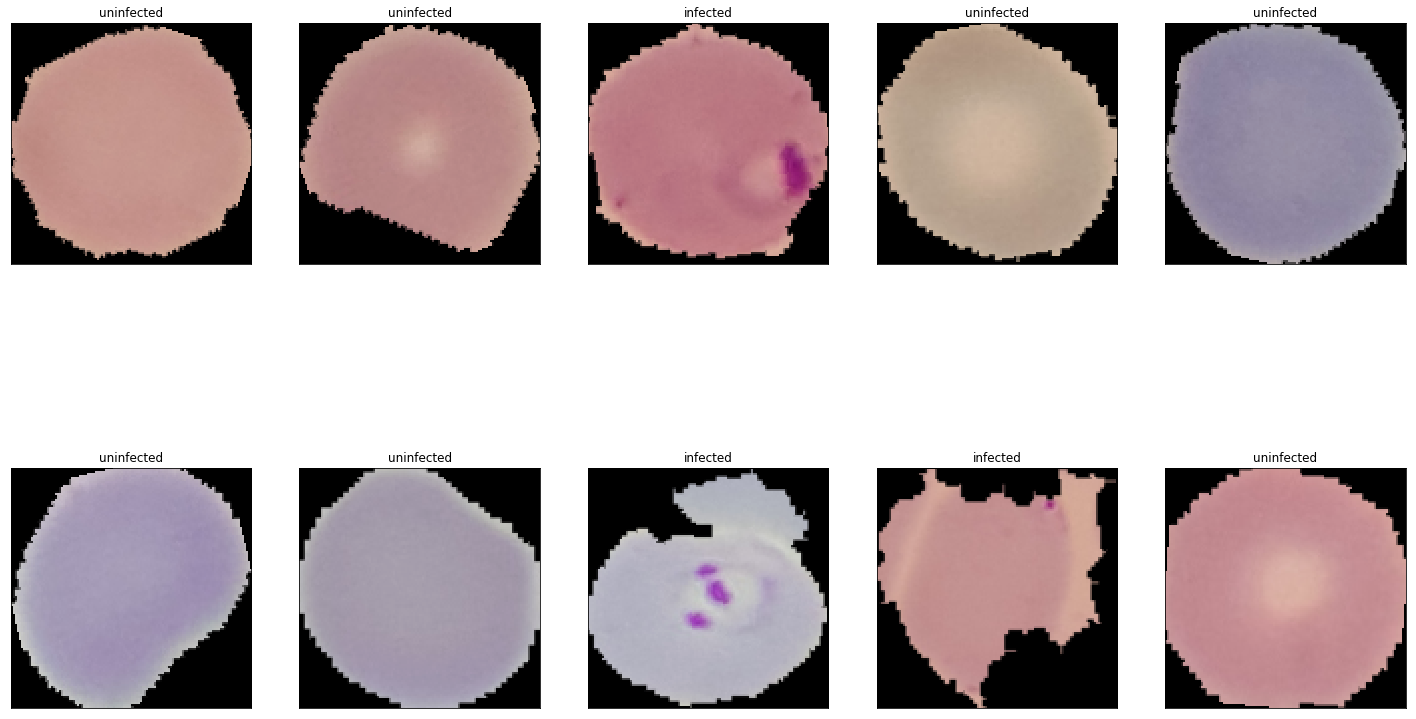

In [19]:
# Visualizing some Images...
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(25, 15))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[], title=classes[labels[i]])
    imshow(images[i])
plt.show()

### CNN classifier

In [20]:
class MosquitoNet(nn.Module):
    
    def __init__(self):
        super(MosquitoNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
            
        self.fc1 = nn.Linear(64*15*15, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)
        self.drop = nn.Dropout2d(0.2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)    # flatten out a input for Dense Layer
        out = self.fc1(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.fc3(out)
        
        return out
        

> Making a model and defining error and optimizing algorithm.

In [23]:
model = MosquitoNet()
model.to(device)
error = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

MosquitoNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=14400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=12

### Training a Model

In [24]:
num_epochs = 20
batch_size = 100 

for epoch in range(num_epochs):
    train_loss = 0.
    model.train()    # explictily stating the training
    
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        train = images.view(-1, 3, 120, 120)
        outputs = model(train)
        
        optimizer.zero_grad()
        loss = error(outputs, labels)
        loss.backward()    #back-propagation
        optimizer.step()
        
        train_loss += loss.item() * batch_size
     
    print("Epoch: {}, Loss: {:.4f}".format(epoch + 1, train_loss / len(train_loader.dataset)))

Epoch: 1, Loss: 0.3256
Epoch: 2, Loss: 0.1396
Epoch: 3, Loss: 0.1262
Epoch: 4, Loss: 0.1095
Epoch: 5, Loss: 0.1085
Epoch: 6, Loss: 0.1045
Epoch: 7, Loss: 0.1016
Epoch: 8, Loss: 0.0985
Epoch: 9, Loss: 0.0937
Epoch: 10, Loss: 0.0983
Epoch: 11, Loss: 0.0942
Epoch: 12, Loss: 0.0900
Epoch: 13, Loss: 0.0895
Epoch: 14, Loss: 0.0871
Epoch: 15, Loss: 0.0857
Epoch: 16, Loss: 0.0855
Epoch: 17, Loss: 0.0834
Epoch: 18, Loss: 0.0803
Epoch: 19, Loss: 0.0821
Epoch: 20, Loss: 0.0811


### Testing a model

In [26]:
correct = 0
total = 0
class_total = [0 for _ in range(2)]
class_correct = [0 for _ in range(2)]
batch_size = 58
# Lists used in Confusion Matrix
actual = []
predict = []

model.eval()    # explicitly stating the testing 
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to (device)
        
        actual.append(labels.data.tolist())
        test = images.view(-1, 3, 120, 120)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        predict.append(predicted.data.tolist())
        total += len(labels)
        correct += (predicted == labels).sum().item()
        # Calculating classwise accuracy
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        
print("Accuracy on the Test set: {:.2f}%".format(correct * 100 / total))
print()
for i in range(2):
    print("Accuracy of {} :  {:.2f}%   [{} / {}]".format(classes[i], class_correct[i] * 100 / class_total[i], 
                                           class_correct[i], class_total[i]))

Accuracy on the Test set: 96.21%

Accuracy of infected :  94.83%   [2660 / 2805]
Accuracy of uninfected :  97.63%   [2641 / 2705]


> Calculating a Confusion Matrix

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import itertools

#flatten out 2D list into 1D
actual = list(itertools.chain.from_iterable(actual))
predict = list(itertools.chain.from_iterable(predict))


In [28]:
results = confusion_matrix(actual, predict)
print("Accuracy Score: ")
print("{:.4f}".format(accuracy_score(actual, predict)))
print()
print("Report: ")
print(classification_report(actual, predict))
print()
print("Confusion Matrix: ")
print(pd.DataFrame(results, columns=["Predicted No", "Predicted Yes"], index=["Actual No", "Actual Yes"]))

Accuracy Score: 
0.9621

Report: 
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2805
           1       0.95      0.98      0.96      2705

   micro avg       0.96      0.96      0.96      5510
   macro avg       0.96      0.96      0.96      5510
weighted avg       0.96      0.96      0.96      5510


Confusion Matrix: 
            Predicted No  Predicted Yes
Actual No           2660            145
Actual Yes            64           2641


In [ ]:
torch.save(model.state_dict(), "model.pt")